In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Data sets used 

All of the various mRS probability data sets are gathered here for time=0 and time=$T_0$, i.e. no effect time.

Any data sets containing mRS=6 (death) have the associated probability $P(mRS=6)$ removed, and the remaining values are normalised so that $P(mRS\leq5)=1.0$.

+ nLVO - non-large-vessel occlusion
+ LVO - large-vessel occlusion

Arrays are named using these strings:
+ `mrs_prob_dist` - mRS distribution
+ `mrs_prob_bins` - cumulative probabilities of `mrs_prob_dist`
+ `t0_treatment` and `no_treatment` - time $t=0$hr and the no-effect time $t=T_{NE}$. 

Plus more specific labels are appended. 

mRS distribution arrays used here:

| Description | $t=0$ | $t=T_{NE}$ | 
| :-- | :-- | :-- |
| Pre-stroke | `_t0_treatment_pre` <br /> The estimated pre-stroke mRS scores from SSNAP data, as used in the SAMueL-1 project. | N/A |
|Haemorrhaegic | N/A | _(yet to find)_ |
| nLVO & LVO combined | `_t0_treatment_?` <br /> Found by combining the no-effect time data (from the Lees+2010 no-treatment control group) with the odds ratio of mRS$\leq$1 at $t=1$hrs (from Emberson+2014). The mRS$\leq$1 data are combined to find P(mRS$\leq$1, $t$=0hr), and then this point is used to scale up an existing t=0 probability distribution (from ...???). | `_no_treatment_Lees` <br /> The no-treatment control group from Lees+2010. Although the numbers in the distribution are not listed in Lees+2010, they have been measured from Figure 1(?). |
| nLVO - untreated | N/A | `_no_treatment_nLVO` <br /> Weighted combination of `_no_treatment_Lees` (100%) and `_no_treatment_LVO` (40%), then further scaled to match $P(mRS<=1, t=T_0)=0.46$ from Holodinsky+2018. |
| nLVO - thrombolysis | `_t0_treatment_nLVOoly` <br /> Weighted combination of `_t0_treatment_pre` (87%) and `_no_treatment_nLVO` (13%), where weights are chosen to match the $P(mRS<=1, t=0)=0.63$ from Holodinsky+2018. | Same as above. |
| LVO - untreated | N/A | `_no_treatment_LVO` <br /> Goyal+2016 control population. |
| LVO - thrombolysis only | `_t0_treatment_LVOoly` <br /> Weighted combination of `_no_treatment_LVO` (82%) and `_t0_treatment_pre` (18%). | Same as above. |
| LVO - thrombectomy <br /> with/out thrombolysis | `_t0_treatment_LVOect` <br /> No effect of stroke, therefore same mRS as pre-stroke. | Same as above. | 

### References:

- Holodinsky+2018
- Goyal+2016
- Emberson+2014
- Lees+2010


---

### Function for scaling existing distributions to match a new data point:

(originally from mRS_outcomes.ipynb)

In [4]:
def get_p1(p2, OR, T_NE = 6.3):
    """
    Use (a known odds ratio for a reference mRS and time=1hr) with (the known T_F probability)
    to find (the t=0 probability).
    
    Must have reference time 1hr to use these simplified equations for a and b.
    
    Inputs:
    p2      - float. Prob. P(mRS<=mRS_ref, t=T_F).
    OR      - float. Odds ratio at t=1hr for scaling.
    T_NE     - float. Treatment non-effect time. 
    
    Returns:
    p1      - float. P(mRS<=mRS_ref, t=0) at time zero. 
    """
    
    # OR = odds ratio for mRS <= mRS_ref
    
    # set log odds = 0 at T_NE to find gradient
    
    # solve for a (see maths cell) :
    # a = np.log(OR) - b: 
    # a = -T_NE b
    a = np.log(OR)/(1 - 1/T_NE)
    
    # Find b (see maths cell)
    b = -a/T_NE
    
    # p1 = probability mRS <=mRS_ref at t=0
    # From odds ratio (see maths cell):
    lhs = np.exp(a)*p2/(1-p2)
    
    p1 = lhs/(1+lhs)
    
    return p1

In [5]:
def get_scaled_dist(dist,p_ref,mRS_ref):
    """
    Scale an existing distribution of probabilities to match a new data point.
    
    Inputs:
    dist    - list or np.array. Prob. dist to be scaled.
    p_ref   - Reference probability.
    mRS_ref - The mRS bin of this reference probability. 
    
    Returns:.
    mrs_prob_mrs_prob_dist_sc - np.array. Prob. dist after scaling.
    mrs_prob_bins_sc - np.array. Cumulative prob. dist after scaling.
    """
   
    # scale bins around p_ref
    
    bins = np.cumsum(dist)
    
    mrs_prob_bins_sc = np.zeros_like(bins)
    
    
    # See plots in mRS_outcomes notebook to better explain this "for" loop.
    #     
    # Basically, in the initial distribution the gap A between P(mRS=n) and P(mRS_ref)  
    # is X% of the gap B between P(mRS_ref) and 0 (n<mRS_ref) or 1 (n>mRS_ref).
    # Then for the new scaled distribution, once P(n<=m_RS_ref) has been set to p_ref,
    # the equivalent gap A1 should take up X% of the gap B1.
    for mRS in range(6):
    
        if mRS<=mRS_ref:
            # Scale the bins that lie below the known data point.
            # When mRS=1, mrs_prob_mrs_prob_bins_t0_treatment_oly[1] = p1.
            mrs_prob_bins_sc[mRS] = p_ref*(bins[mRS]/bins[mRS_ref])

        else:
            # Scale the bins that lie above the known data point.
            # The p1+ adds a y-offset from zero. 
            mrs_prob_bins_sc[mRS] =  p_ref + (1-p_ref)*(bins[mRS]-bins[mRS_ref])/(1-bins[mRS_ref])
    
    # use bins to obtain distribution
        
    mrs_prob_bins_sc = np.concatenate(([0],mrs_prob_bins_sc))

    mrs_prob_mrs_prob_dist_sc = np.diff(mrs_prob_bins_sc)
    
    return mrs_prob_mrs_prob_dist_sc, mrs_prob_bins_sc

---

# Pre-stroke

Plot the distribution of mRS at time T=0 (i.e. before stroke) from the SAMuel-1 data set. P(mRS=6)=0.

In [6]:
mrs_prob_dist_t0_treatment_pre = np.array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674, 0.0186443 ])

Convert the mRS distribution into cumulative frequency:

In [7]:
mrs_prob_bins_t0_treatment_pre = np.cumsum(np.concatenate(([0],mrs_prob_dist_t0_treatment_pre)))

In [8]:
mrs_prob_bins_t0_treatment_pre

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

---

# Haemorrhaegic

## t=0 distribution

N/A

## "No effect" distribution

_Yet to find this_

---

# nLVO and LVO combined

## "No effect" distribution

The Lees+2020 values were measured in mRS_outcomes.ipynb using Powerpoint. 

In [9]:
# Lees+2010 distribution:
mrs_prob_dist_no_treatment_Lees = np.array([ 0.16841002, 0.2291431, 0.14193671, 0.15825232, 0.2046646, 0.09759325])
# mrs_prob_dist_no_treatment_LVO = np.array([0.05,       0.079,     0.136,      0.164,      0.247,     0.135])

# Create cumulative probability:
mrs_prob_bins_no_treatment_Lees = np.cumsum(np.concatenate(([0.0],mrs_prob_dist_no_treatment_Lees)))

In [10]:
mrs_prob_dist_no_treatment_Lees

array([0.16841002, 0.2291431 , 0.14193671, 0.15825232, 0.2046646 ,
       0.09759325])

In [11]:
mrs_prob_bins_no_treatment_Lees

array([0.        , 0.16841002, 0.39755312, 0.53948983, 0.69774215,
       0.90240675, 1.        ])

## t=0 distribution

Use the "no effect" distribution with the t=1hr value from Emberson+2014 to extrapolate back and find a t=0hr point, then scale the ... SOMETHING... back to match

In [12]:
OR = 1.9
mRS_ref = 1

# p2 from distribution if not treated
# (index+1 because mrs_prob_mrs_prob_bins_no_treatment_oly contains 0.0 at start)
p2 = mrs_prob_bins_no_treatment_Lees[mRS_ref+1]


# is no effect time 6.3hr?

In [13]:
p1 = get_p1(p2, OR, T_NE = 6.3)

In [14]:
mrs_prob_dist_t0_treatment_sc, mrs_prob_bins_t0_treatment_sc = get_scaled_dist(mrs_prob_dist_t0_treatment_pre,p1,mRS_ref)

---

# LVO - untreated 

## t=0 distribution

N/A

## "No effect" distribution

Collect "untreated" mRS distribution, i.e. mRS at time T=8hrs.
_Presumably_ this only includes patients when no thrombolysis or thrombectomy has been performed.

Data from Goyal+2016[1], Figure 1 (A Overall, Control population). mRS=6 is excluded and P(mRS=6)=0.189.

[1] _"Endovascular thrombectomy after large-vessel ischaemic stroke: a meta-analysis of individual patient data from five randomised trials"_

In [15]:
#from golye's control population (figure 1a)

mrs_prob_dist_no_treatment_LVO = np.array([0.05, 0.079, 0.136, 0.164, 0.247, 0.135])

# Need to normalise because it currently doesn't add up to 1 (non-zero mRS=6 is excluded).
mrs_prob_dist_no_treatment_LVO = mrs_prob_dist_no_treatment_LVO/np.sum(mrs_prob_dist_no_treatment_LVO)

In [16]:
mrs_prob_dist_no_treatment_LVO

array([0.06165228, 0.0974106 , 0.1676942 , 0.20221948, 0.30456227,
       0.16646116])

Convert to cumulative frequency:

In [17]:
mrs_prob_bins_no_treatment_LVO = np.cumsum(np.concatenate(([0],mrs_prob_dist_no_treatment_LVO)))

In [18]:
mrs_prob_bins_no_treatment_LVO

array([0.        , 0.06165228, 0.15906289, 0.32675709, 0.52897657,
       0.83353884, 1.        ])

---

# LVO - thrombolysis only 

## t=0 distribution

Weighted distribution of full effect `mrs_prob_dist_t0_treatment_pre` and no effect `mrs_prob_dist_no_treatment_LVO`, 0.18:0.82. (as in Holodinsky paper).

In [19]:
# Define the weights 'w':
w_LVOoly_pre = 0.18
w_LVOoly_noe = 0.82

mrs_prob_dist_t0_treatment_LVOoly = w_LVOoly_pre*mrs_prob_dist_t0_treatment_pre + w_LVOoly_noe*mrs_prob_dist_no_treatment_LVO
# Normalise:
mrs_prob_dist_t0_treatment_LVOoly = mrs_prob_dist_t0_treatment_LVOoly / np.sum(mrs_prob_dist_t0_treatment_LVOoly)

# Create bins:
mrs_prob_bins_t0_treatment_LVOoly = np.cumsum(mrs_prob_dist_t0_treatment_LVOoly)

In [20]:
mrs_prob_dist_t0_treatment_LVOoly

array([0.14947714, 0.10668805, 0.15516151, 0.1870043 , 0.26181487,
       0.13985412])

In [21]:
mrs_prob_bins_t0_treatment_LVOoly

array([0.14947714, 0.25616519, 0.4113267 , 0.598331  , 0.86014588,
       1.        ])

## "No effect" distribution

Goyal+2016 control population - use `mrs_prob_dist_no_treatment_LVO` and `mrs_prob_bins_no_treatment_LVO`.

---

# LVO - thrombectomy (with or without thrombolysis) 

## t=0 distribution

Assume no effect of stroke, therefore use same mRS as pre-stroke.

In [22]:
mrs_prob_dist_t0_treatment_LVOect = mrs_prob_dist_t0_treatment_pre

mrs_prob_bins_t0_treatment_LVOect = mrs_prob_bins_t0_treatment_pre

In [23]:
mrs_prob_dist_t0_treatment_LVOect

array([0.54956819, 0.14895196, 0.0980681 , 0.11769072, 0.06707674,
       0.0186443 ])

In [24]:
mrs_prob_bins_t0_treatment_LVOect

array([0.        , 0.54956819, 0.69852015, 0.79658825, 0.91427897,
       0.98135571, 1.00000001])

## "No effect" distribution

Goyal+2016 control population - use `mrs_prob_dist_no_treatment_LVO` and `mrs_prob_bins_no_treatment_LVO`.

---

# nLVO - untreated

## t=0 distribution

N/A

## "No effect" distribution

Estimate from weighted subtraction of Goyal+2016 data from the Lees+2010 data. Assume 60% nLVO and 40% LVO and then refine - with the 60/40 balance, the P(mRS<=5) bin ends up being negative. The closest weighting that prevents this is 64%/36%.

In [25]:
# Define the weights 'w':
w_nLVO_nLVO = 1.0 #
w_nLVO_LVO  = 0.4 #1.0-w_nLVO_nLVO

mrs_prob_bins_no_treatment_nLVO = w_nLVO_nLVO*mrs_prob_bins_no_treatment_Lees - w_nLVO_LVO*mrs_prob_bins_no_treatment_LVO

# Normalise:
mrs_prob_bins_no_treatment_nLVO = mrs_prob_bins_no_treatment_nLVO / mrs_prob_bins_no_treatment_nLVO[-1]

mrs_prob_dist_no_treatment_nLVO = np.diff(mrs_prob_bins_no_treatment_nLVO)

In [26]:
mrs_prob_dist_no_treatment_nLVO

array([0.23958185, 0.31696476, 0.12476505, 0.12894088, 0.13806615,
       0.05168131])

In [27]:
mrs_prob_bins_no_treatment_nLVO

array([0.        , 0.23958185, 0.55654661, 0.68131166, 0.81025254,
       0.94831869, 1.        ])

Check whether mRS<=1 value is a match for the 46% value from Holodinsky+2018.

In [28]:
mrs_prob_bins_no_treatment_nLVO[2]

0.556546609782162

Scale the bins to match the value from Holodinsky+2018, $P(mRS\leq1, t=T_0)=0.46$.

In [29]:
mRS_ref_nLVO = 1
p_ref_nLVO   = 0.46

In [30]:
mrs_prob_dist_t0_treatment_nLVO, mrs_prob_bins_t0_treatment_nLVO = get_scaled_dist(mrs_prob_dist_no_treatment_nLVO,p_ref_nLVO,mRS_ref_nLVO)

In [31]:
mrs_prob_dist_t0_treatment_nLVO

array([0.19802052, 0.26197948, 0.15192831, 0.15701329, 0.16812528,
       0.06293313])

In [32]:
mrs_prob_bins_t0_treatment_nLVO

array([0.        , 0.19802052, 0.46      , 0.61192831, 0.7689416 ,
       0.93706687, 1.        ])

---

# nLVO - thrombolysis

## t=0 distribution

Weighted distribution of the pre-stroke and "no effect" distributions.

Find the weighting that results in $P(mRS<=1, t=0)=0.63$ (from Holodinsky+2018).

In [33]:
# Define the weights 'w':
w_nLVOoly_pre = (0.63 - mrs_prob_bins_no_treatment_LVO[2]) / (mrs_prob_bins_t0_treatment_pre[2] - mrs_prob_bins_no_treatment_LVO[2])
w_nLVOoly_noe = 1.0 - w_nLVOoly_pre

print('Weights: ', w_nLVOoly_pre, w_nLVOoly_noe)

mrs_prob_bins_t0_treatment_nLVOoly = w_nLVOoly_pre*mrs_prob_bins_t0_treatment_pre + w_nLVOoly_noe*mrs_prob_bins_no_treatment_LVO

mrs_prob_dist_t0_treatment_nLVOoly = np.diff(mrs_prob_bins_t0_treatment_nLVOoly)

Weights:  0.8729831731128811 0.1270168268871189


In [34]:
mrs_prob_dist_t0_treatment_nLVOoly

array([0.48759466, 0.14240534, 0.10691179, 0.1284273 , 0.0972414 ,
       0.03741953])

In [35]:
mrs_prob_bins_t0_treatment_nLVOoly

array([0.        , 0.48759466, 0.63      , 0.73691179, 0.86533908,
       0.96258048, 1.00000001])

## "No effect" distribution

Same as for untreated nLVO.

---

# Plotting

In [36]:
def plot_two_hists(mrs_prob_dist_0=[],mrs_prob_dist_F=[],title=''):
    # Compare histograms of the full data at t=0 and t=untreated:
    fig, axs = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.04})
    ax0 = axs[0]
    axF = axs[1]
    
    # Fudge the histogram by multiplying all dist values by 1000,
    # generating a fudge dataset with that many values in, 
    # and plotting the fudge.
    dists = [mrs_prob_dist_0, mrs_prob_dist_F]
    for i,dist in enumerate(dists):
        fdist = []
        if len(dist)>0:
            for b in range(len(dist)):
                fdist += [b]*int(dist[b]*1000)
            # Draw the histograms:
            dist0, bins0, _ = axs[i].hist(fdist, bins=[0,1,2,3,4,5,6,7], 
                                          density=True, width=0.6, align='mid')

        # Sanity check:
        axs[i].scatter(range(len(dist)),dist)
    
    
    # Share y axis:
    for ax in [ax0,axF]:
        ax.set_xlabel('mRS')
        ax.set_ylabel('P(mRS)')
        ax.set_xlim(-0.3,6.9)
        ax.set_ylim(0.0,0.6)
        ax.tick_params(right=True,left=True)

            
    # Add labels for clarity:
    ax0.annotate('Time 0hr',xy=(0.0,ax0.get_ylim()[1]*0.95),va='center',ha='left')
    axF.annotate('Time of no effect',xy=(0.0,axF.get_ylim()[1]*0.95),
                 va='center',ha='left')


    # Move RHS plot's y-axis labels to its right:
    axF.yaxis.tick_right()
    axF.yaxis.set_label_position('right')

    # Remind RHS axis to put tick marks on left:
    axF.tick_params(left=True)
    
    fig.suptitle(title)
    plt.show()
    
    # Sanity check:
    print('Sums of the plotted distributions (LHS, RHS): ', np.sum(mrs_prob_dist_0), np.sum(mrs_prob_dist_F))

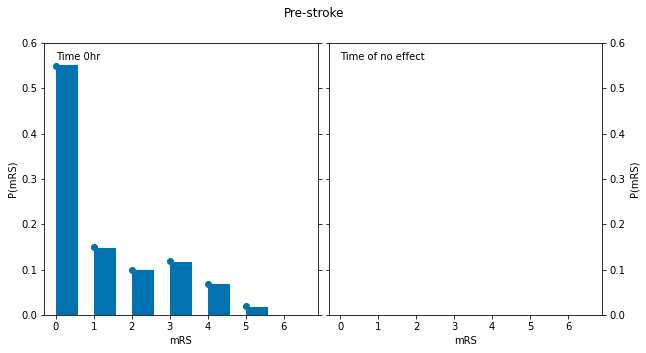

Sums of the plotted distributions (LHS, RHS):  1.00000001 0.0


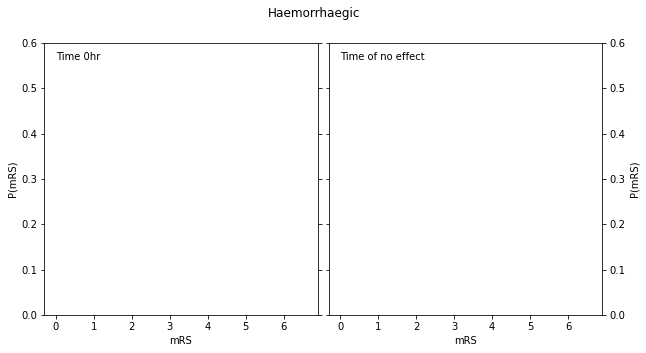

Sums of the plotted distributions (LHS, RHS):  0.0 0.0


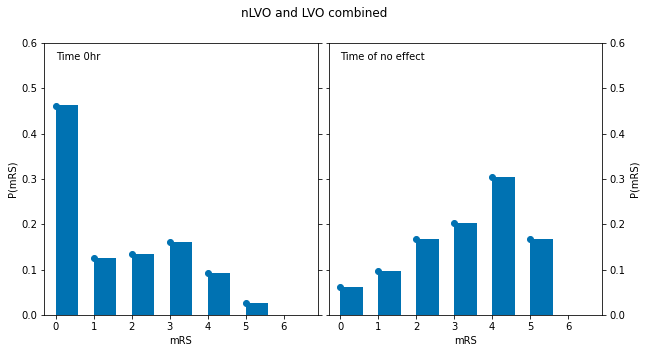

Sums of the plotted distributions (LHS, RHS):  1.0000000137335996 1.0


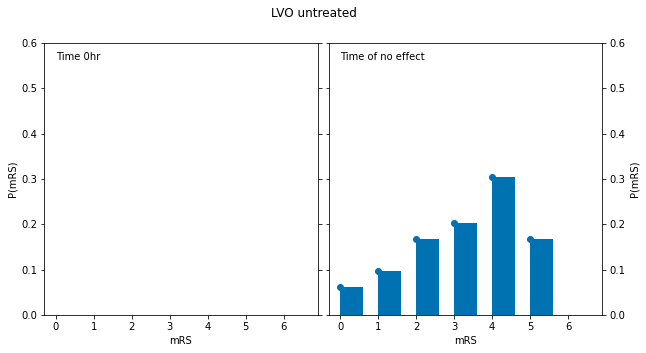

Sums of the plotted distributions (LHS, RHS):  0.0 1.0


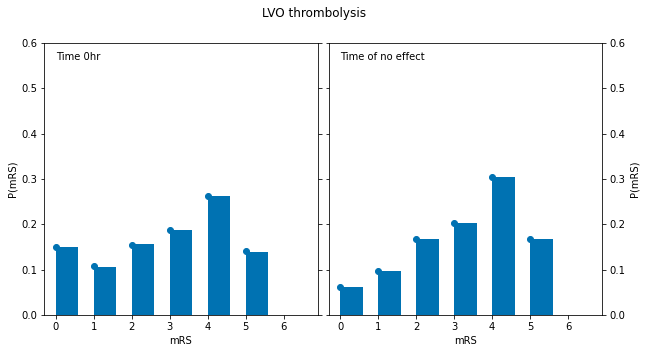

Sums of the plotted distributions (LHS, RHS):  1.0000000000000002 1.0


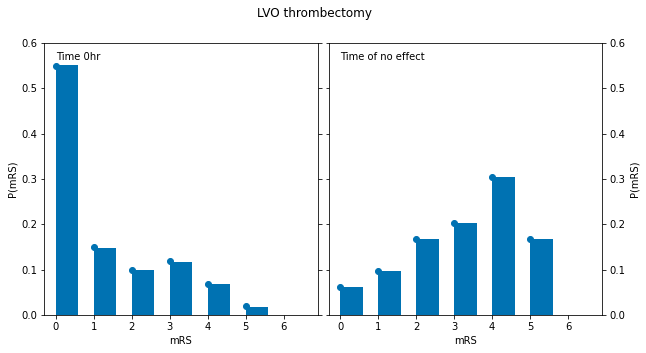

Sums of the plotted distributions (LHS, RHS):  1.00000001 1.0


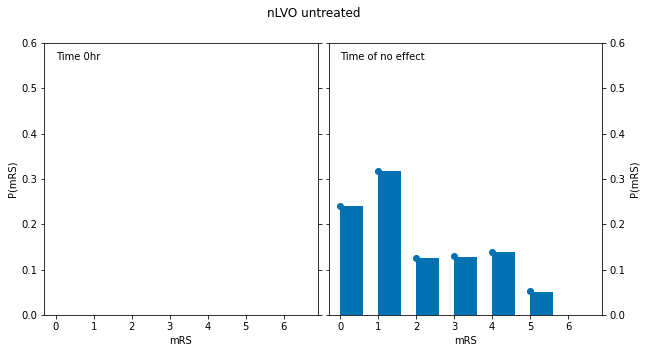

Sums of the plotted distributions (LHS, RHS):  0.0 1.0


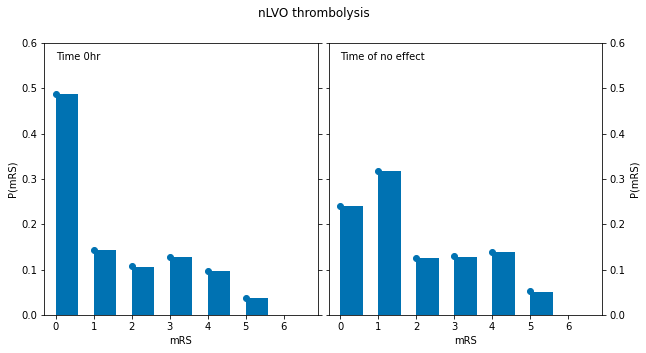

Sums of the plotted distributions (LHS, RHS):  1.0000000087298315 1.0


In [37]:
# Haemorrhaegic:
plot_two_hists(mrs_prob_dist_t0_treatment_pre,[],title='Pre-stroke')

# Haemorrhaegic:
plot_two_hists([],[],title='Haemorrhaegic')

# nLVO and LVO combined:
plot_two_hists(mrs_prob_dist_t0_treatment_sc, mrs_prob_dist_no_treatment_LVO, title='nLVO and LVO combined')

# LVO untreated:
plot_two_hists([], mrs_prob_dist_no_treatment_LVO, title='LVO untreated')

# LVO thrombolysis only:
plot_two_hists(mrs_prob_dist_t0_treatment_LVOoly, mrs_prob_dist_no_treatment_LVO, title='LVO thrombolysis')

# LVO thrombectomy with/out thrombolysis:
plot_two_hists(mrs_prob_dist_t0_treatment_pre, mrs_prob_dist_no_treatment_LVO, title='LVO thrombectomy')

# nLVO untreated:
plot_two_hists([], mrs_prob_dist_no_treatment_nLVO, title='nLVO untreated')

# nLVO thrombolysis:
plot_two_hists(mrs_prob_dist_t0_treatment_nLVOoly, mrs_prob_dist_no_treatment_nLVO, title='nLVO thrombolysis')
